# Lenet

In [2]:
import os
import sys

NOTEBOOK_PATH = os.getcwd()
FASTER_RCNN_PATH = NOTEBOOK_PATH + "/../"
CAFFE_PATH = FASTER_RCNN_PATH + "caffe-fast-rcnn/python"

sys.path.append(FASTER_RCNN_PATH)
sys.path.append(CAFFE_PATH)

import caffe

In [3]:
from pylab import *
%matplotlib inline

In [4]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, 
                             backend=P.Data.LMDB, 
                             source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)

    n.conv1 = L.Convolution(n.data, kernel_size=5,
                                    num_output=20,
                                    weight_filler=dict(type='xavier'))
    
    n.pool1 = L.Pooling(n.conv1, kernel_size=2,
                                 stride=2,
                                 pool=P.Pooling.MAX)
    
    n.conv2 = L.Convolution(n.pool1, kernel_size=5,
                                     num_output=50,
                                     weight_filler=dict(type="xavier"))
    
    n.pool2 = L.Pooling(n.conv2, kernel_size=2,
                                 stride=2,
                                 pool=P.Pooling.MAX)
    
    n.fc1 = L.InnerProduct(n.pool2, num_output=500,
                                    weight_filler=dict(type='xavier'))
    
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

In [6]:
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('/home/kelly/Studio/kelly/k/py-faster-rcnn-dev/fasterrcnn/py-faster-rcnn/caffe-fast-rcnn/examples/mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('/home/kelly/Studio/kelly/k/py-faster-rcnn-dev/fasterrcnn/py-faster-rcnn/caffe-fast-rcnn/examples/mnist/mnist_test_lmdb', 100)))

In [7]:
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "/home/kelly/Studio/kelly/k/py-faster-rcnn-dev/fasterrcnn/py-faster-rcnn/caffe-fast-rcnn/examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name

In [8]:
!cat mnist/lenet_auto_test.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "/home/kelly/Studio/kelly/k/py-faster-rcnn-dev/fasterrcnn/py-faster-rcnn/caffe-fast-rcnn/examples/mnist/mnist_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name

In [9]:
caffe.set_mode_cpu()

solver = None
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [10]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [11]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()] 

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [12]:
solver.net.forward()

{'loss': array(2.428609848022461, dtype=float32)}

In [13]:
# data
print solver.net.blobs['data'].data.shape
print solver.net.blobs['data'].data[...]

(64, 1, 28, 28)
[[[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   ..., 
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]]]


 [[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   ..., 
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]]]


 [[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   ..., 
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]]]


 ..., 
 [[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   ..., 
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]]]


 [[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   ...,

In [14]:
solver.test_nets[0].forward()

{'loss': array(2.3746352195739746, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


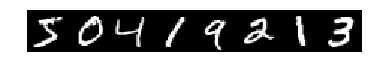

In [15]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


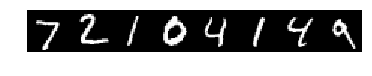

In [16]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

In [17]:
solver.step(1)

(-0.5, 24.5, 19.5, -0.5)

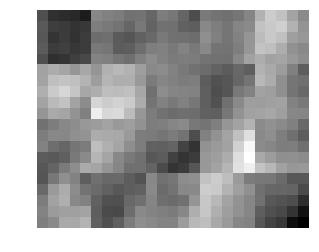

In [18]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')